|  Surname | Name   | Matricola   | Accademic Mail   |
|---|---|---|---|
|Rossetto   | Eric     | 982594  | eric.rossetto@studio.unibo.it |
|Wen          | Xiaowei   | 982501  | xiaowei.wen@studio.unibo.it  |  


MSc student in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
August, 2021

# Importing libraries

In [1]:
from z3 import *
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatches
import time
import json

# Defining functions 

In [2]:
def read_instance_text(f):
    """ 
    It reads the instance data, in the following format:
    width
    n_circuits
    Wi, Hi for i in range(n_circuits)
    returns a tuple as (width, List of Wi, List of Hi)
    """
    # print(f)
    file = open(f)
    w = int(file.readline())
    # print("width ", width)
    n_piece = int(file.readline())
    W, H = [], []
    for i in range(n_piece):
        piece = file.readline()
        split_piece = piece.strip().split(" ")
        W.append((int(split_piece[0])))
        H.append((int(split_piece[1])))
    # print(pieces)
    return w, W, H


def show_shape(s, title, n_circuits):
    """
    create a image with s as image and title as title of the graph
    :param s:
    :param title:
    :param n_circuits:
    :return:
    """
    s = cv2.merge([s])
    img = plt.imshow(s)

    values, counts = np.unique(s, return_counts=True)
    # print(counts)
    colors = [img.cmap(img.norm(value)) for value in values]
    labels = []
    starting = 0
    if n_circuits + 1 == len(counts):
        starting = 1
        labels.append("Background")
    for i in range(starting, len(counts)):
        labels.append(f"Piece {i + 1}")
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(counts))]
    plt.title(title)
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(list(range(0, s.shape[1] + 1)))
    yticks = list(range(0, s.shape[0]))
    # yticks.reverse()
    plt.yticks(yticks)
    plt.ylim(top=s.shape[0])
    plt.ylim(bottom=-0.5)
    plt.xlim(left=-0.5)
    plt.xlim(right=s.shape[1])
    plt.gca().invert_yaxis()
    # plt.grid(b=True)
    # plt.savefig(f"{title}")

    plt.show()


def draw_solution(sol_shape, pieces):
    """
    Returns an array with shape = sol_shape, and pieces drawn in the array
    """
    arr = np.zeros(sol_shape)
    count = 1
    # area = 0
    for x_t, y_t, x, y in pieces:
        arr[x:x + x_t, y:y + y_t] = abs(count) * (250 / len(pieces))
        count += 1
        # print(arr)
        # print(area)
    arr = arr / np.max(arr)
    return np.rot90(arr)


def dims_sol_unify(W, H, X, Y):
    """
    It creates a list of tuple, where each tuple is composed by
    (Wi,Hi,Xi,Yi)
    :param W: width of the piece i
    :param H: height of the piece i
    :param X: X component of the piece i
    :param Y: Y component of the piece i
    :return:
    """
    return [(W[i], H[i], X[i], Y[i]) for i in range(len(W))]


def flatten(t):
    """
    Given a list of lists, it returns a flatten version of all lists
    :param t:
    :return:
    """
    return [item for sublist in t for item in sublist]


def save_sol(file_name, w, h, W, H, X, Y):
    """
    Save the solution in file file_name
    :param file_name: path to the file
    :param w: width of the solution
    :param h: height of the solution
    :param W: width of the piece i
    :param H: height of the piece i
    :param X: X component of the piece i
    :param Y: Y component of the piece i
    :return:
    """
    file = open(file_name, mode="w")
    file.write(f"{w} {h}\n")
    file.write(f"{len(X)}\n")
    for i in range(len(W)):
        file.write(f"{W[i]} {H[i]} {X[i]} {Y[i]}\n")
    file.close()


# Defining function for SMT instance

In [16]:
def vlsi_instance(W, H, dims, width, max_height, time_out = 300):
  """
    Variable declaration
    W: width of all circuits
    H: height of all circuits
    dims: number of circuits
    width: width of the board/ solution
    max_height: maximum height reachable by stacking all circuits. 
    time_out: timeout for the solver in seconds
  """
  # decision variable for the height
  all_constraints = []
  height = Int('height')

  # X component of the solution where to place the circuits
  X = [Int(f"X_{i}") for i in range(dims)]
  
  # Y component of the solution where to place the circuits
  Y = [Int(f"Y_{i}") for i in range(dims)]

  # width boundaries constraints
  boundaries_c_width = [And(0 <= X[i], W[i]+ X[i]<= width) for i in range(dims)]
  all_constraints+= boundaries_c_width

  # height boundaries constraints
  boundaries_c_height = [0 <= Y[i] for i in range(dims)] #+ np.max([Y[i]+H[i]for i in range(dims)], dtype= int)< height
  all_constraints += boundaries_c_height

  biggest_H = int(np.argmax(H))
  # symmetry breaking 
  all_constraints +=  [And(X[biggest_H]*2 <=width,Y[biggest_H]*2 <=width)]

  # height constraints
  height_constraint = [Y[i]+H[i]<=height for i in range(dims)]
  all_constraints += height_constraint

  # no overlapping constraints
  no_overlapping = []    
  for i in range(dims):
    for j in range(dims): # to fix
      if i != j:
        no_overlapping.append(
                Or(X[i] + W[i] <= X[j],
                Y[i] + H[i] <= Y[j],
                X[i] - W[j] >= X[j],
                Y[i] - H[j] >= Y[j])) 
  all_constraints += no_overlapping

  """
    Solving phase
  """
  solver = Optimize()
  # print(str(all_constraints))
  solver.add(all_constraints)
  # minimizing function
  if time_out!= -1:
    solver.set("timeout",time_out*1000)
  solver.minimize(height)
  if solver.check() == sat:
    m = solver.model()
    return int(m.evaluate(height).as_string()), [int(m.evaluate(X[i]).as_string()) for i in range(dims)],[int(m.evaluate(Y[i]).as_string()) for i in range(dims)]
  else:
    print(solver.reason_unknown())
    return None



# Solving
## reading solution time per instance

In [9]:
time_table = "time.json"
time_per_instance = []
with open(time_table, "r") as f:
    time_json = json.load(f)

## Getting instances 

In [21]:
path = "../../instances/"
# solve all instances in path
instances = os.listdir(path)

# solve a certain range of the instances
# instances = [f"ins-{i}.txt" for i in range (27,41)]

# solve a specified instance
# instances = [f"ins-{11}.txt"]

# solve those unsolved instances
# instances = []
# for key, value in time_json.items():
#   if value == -1:
#     instances.append(key)

    

## Solving instances

Instance 1:
(8, [0, 0, 3, 3], [0, 3, 5, 0])
Solution (width, height): (8, 8), time: 0.2172s


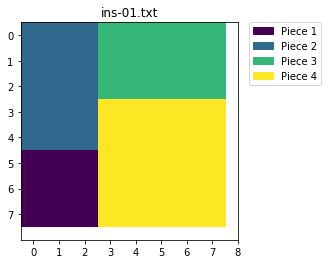

Instance 2:
(9, [6, 0, 0, 6, 3], [0, 0, 4, 3, 0])
Solution (width, height): (9, 9), time: 0.3236s


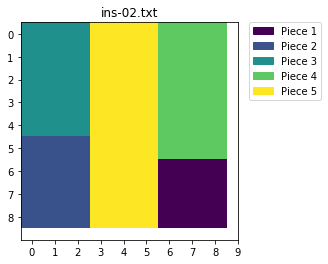

Instance 3:
(10, [0, 3, 7, 0, 6, 3], [0, 0, 4, 3, 0, 4])
Solution (width, height): (10, 10), time: 0.5553s


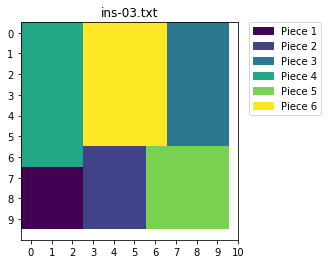

Instance 4:
(11, [3, 3, 0, 0, 6, 6, 3], [8, 0, 0, 5, 8, 0, 4])
Solution (width, height): (11, 11), time: 0.4073s


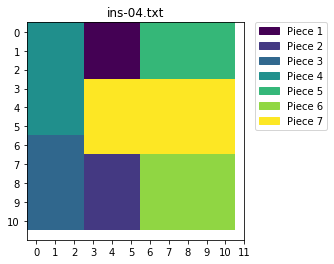

Instance 5:
(12, [3, 9, 0, 3, 0, 9, 6, 3], [0, 8, 0, 3, 5, 0, 0, 9])
Solution (width, height): (12, 12), time: 0.7853s


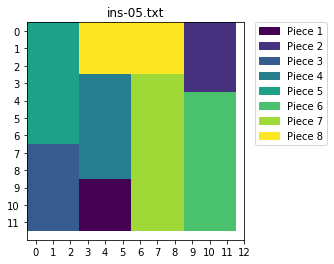

Instance 6:
(13, [3, 7, 0, 3, 10, 0, 6, 3, 6], [0, 9, 0, 3, 6, 5, 6, 9, 0])
Solution (width, height): (13, 13), time: 0.9221s


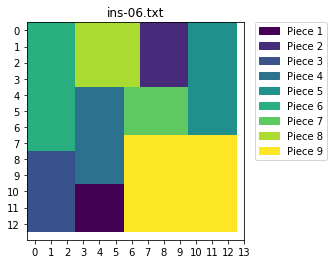

Instance 7:
(14, [0, 0, 3, 11, 0, 11, 3, 6, 6], [0, 3, 9, 0, 7, 6, 0, 10, 0])
Solution (width, height): (14, 14), time: 0.9204s


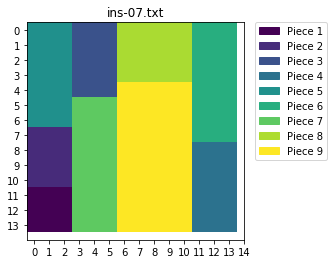

Instance 8:
(15, [0, 0, 9, 3, 9, 0, 3, 12, 6, 9], [12, 0, 7, 9, 0, 4, 0, 0, 0, 12])
Solution (width, height): (15, 15), time: 0.7429s


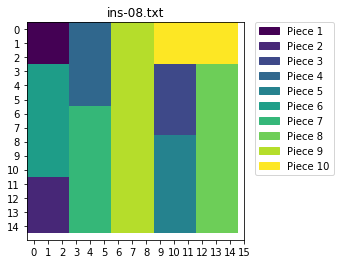

Instance 9:
(16, [3, 0, 3, 6, 13, 3, 6, 0, 9, 9], [5, 12, 0, 10, 9, 8, 0, 0, 9, 0])
Solution (width, height): (16, 16), time: 1.0072s


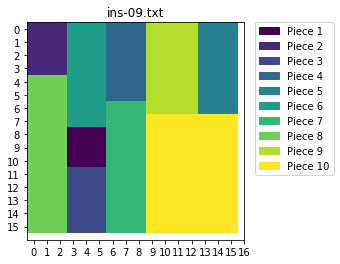

Instance 10:
(17, [11, 0, 11, 0, 0, 14, 7, 3, 7, 3, 10, 10], [5, 7, 0, 11, 0, 0, 8, 14, 0, 0, 8, 11])
Solution (width, height): (17, 17), time: 2.7155s


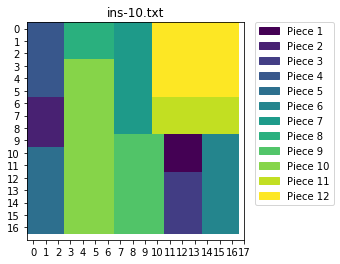

Instance 11:
canceled
Instance 12:
(19, [6, 6, 6, 0, 6, 3, 16, 16, 3, 0, 9, 12, 12, 12], [0, 15, 10, 0, 3, 0, 10, 0, 8, 6, 0, 8, 13, 0])
Solution (width, height): (19, 19), time: 3.5178s


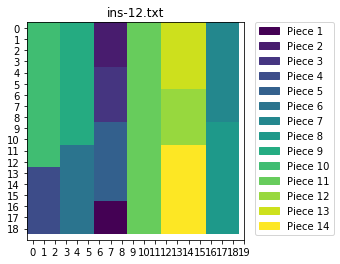

Instance 13:
(20, [7, 4, 10, 4, 10, 10, 13, 4, 13, 7, 16, 0, 0, 16], [0, 0, 0, 4, 5, 12, 0, 10, 9, 3, 0, 0, 9, 3])
Solution (width, height): (20, 20), time: 3.1857s


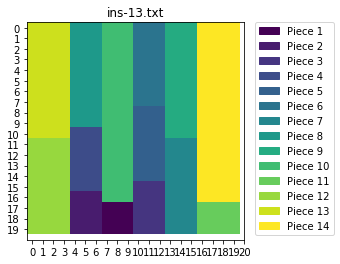

Instance 14:
(21, [10, 7, 18, 13, 0, 3, 3, 18, 0, 10, 3, 6, 6, 16, 13], [0, 17, 10, 15, 0, 0, 8, 0, 7, 3, 17, 0, 6, 15, 0])
Solution (width, height): (21, 21), time: 9.9009s


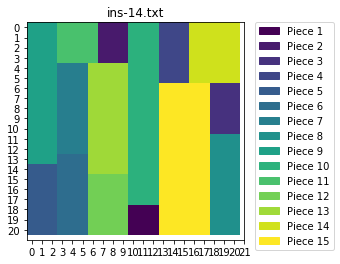

Instance 15:
(22, [15, 3, 0, 6, 0, 15, 12, 0, 15, 6, 12, 3, 9, 18, 18, 3], [19, 18, 0, 4, 15, 0, 0, 5, 8, 10, 9, 4, 0, 19, 0, 0])
Solution (width, height): (22, 22), time: 5.5934s


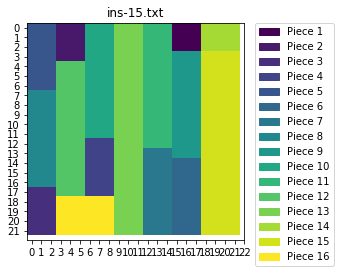

Instance 16:
canceled
Instance 17:
(24, [0, 6, 14, 17, 0, 11, 14, 14, 6, 0, 17, 3, 20, 20, 20, 20, 6, 9], [21, 0, 19, 0, 0, 16, 10, 0, 4, 7, 6, 0, 5, 8, 0, 12, 16, 0])
Solution (width, height): (24, 24), time: 30.3574s


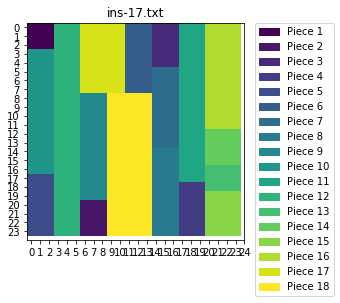

Instance 18:
(25, [6, 16, 6, 0, 22, 22, 19, 22, 3, 19, 3, 6, 16, 0, 9, 12, 12, 12, 16], [5, 3, 0, 19, 10, 17, 3, 0, 0, 12, 11, 8, 7, 0, 0, 7, 0, 12, 0])
Solution (width, height): (25, 25), time: 94.8946s


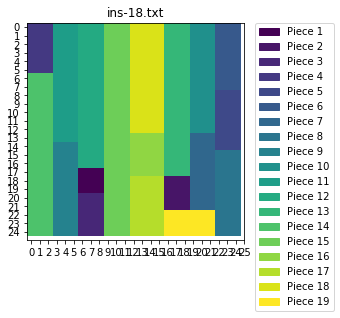

Instance 19:
canceled
Instance 20:
canceled
Instance 21:
canceled
Instance 22:
canceled
Instance 23:
(30, [10, 7, 27, 10, 4, 10, 0, 7, 24, 10, 4, 7, 24, 27, 0, 0, 0, 0, 3, 13], [13, 10, 0, 24, 23, 16, 14, 0, 0, 0, 0, 14, 11, 5, 27, 23, 0, 6, 14, 0])
Solution (width, height): (30, 30), time: 122.1379s


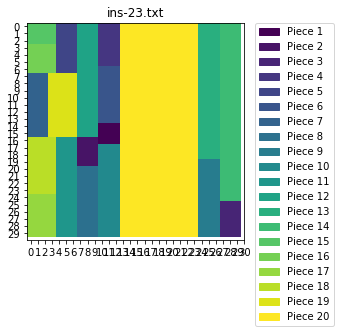

Instance 24:
(31, [0, 12, 3, 0, 3, 3, 6, 6, 3, 6, 12, 12, 0, 9, 15, 15, 15, 15, 19], [6, 0, 15, 0, 8, 0, 22, 12, 20, 0, 4, 17, 9, 0, 28, 0, 7, 15, 0])
Solution (width, height): (31, 31), time: 48.9083s


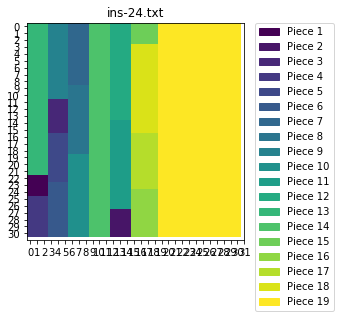

Instance 25:
canceled
Instance 26:
canceled
Instance 27:
(34, [7, 19, 13, 19, 13, 7, 0, 19, 7, 7, 10, 19, 10, 13, 4, 16, 3, 3, 0, 0, 22], [31, 0, 29, 4, 0, 12, 0, 10, 20, 0, 21, 20, 0, 7, 9, 0, 0, 4, 23, 9, 0])
Solution (width, height): (34, 34), time: 289.5963s


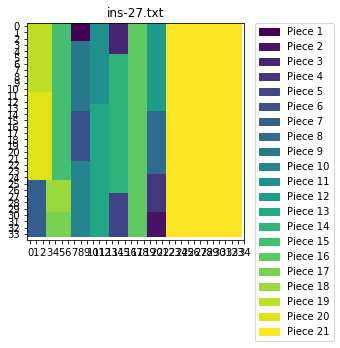

Instance 28:
(35, [32, 29, 32, 0, 0, 32, 32, 32, 25, 25, 0, 21, 25, 28, 28, 21, 21, 17, 21, 28, 17, 3], [32, 31, 27, 0, 28, 0, 18, 8, 0, 12, 6, 0, 31, 0, 5, 28, 3, 23, 11, 11, 0, 0])
Solution (width, height): (35, 35), time: 300.4777s


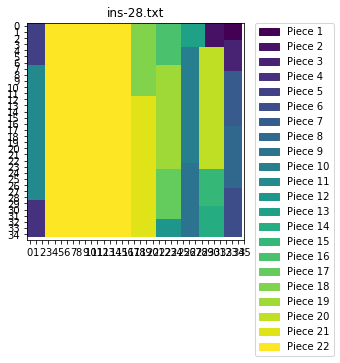

Instance 29:
canceled
Instance 30:
canceled
Instance 31:
(38, [0, 31, 0, 31, 0, 31, 31, 0, 31, 0, 34, 34, 34, 34, 27, 27, 27, 34, 3], [23, 28, 26, 32, 31, 0, 8, 0, 17, 10, 5, 0, 8, 14, 27, 0, 12, 22, 0])
Solution (width, height): (38, 38), time: 78.1535s


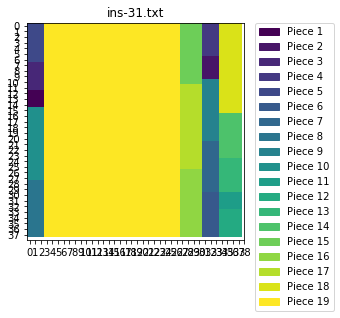

Instance 32:
canceled
Instance 33:
(40, [0, 5, 37, 37, 0, 37, 37, 0, 37, 0, 8, 33, 33, 33, 3, 0, 3, 3, 3, 11], [0, 36, 29, 34, 3, 21, 12, 26, 0, 10, 0, 14, 0, 18, 0, 36, 3, 24, 11, 0])
Solution (width, height): (40, 40), time: 99.5435s


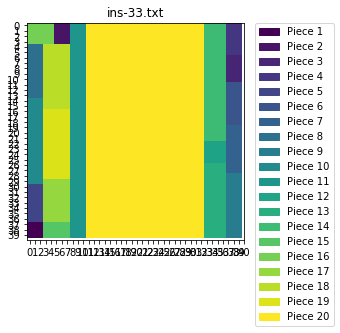

Instance 34:
canceled
Instance 35:
canceled
Instance 36:
canceled
Instance 37:
canceled
Instance 38:
canceled
Instance 39:
canceled
Instance 40:
canceled


In [22]:

for i in range(len(instances)):
    # print(path+instance)
    instance = instances[i]
    print(f"Instance {i+1}:")
    width, W, H = read_instance_text(path + instance)
    # print(dims)
    max_height = np.sum([H[i] for i in range(len(H))], dtype=int)
    # print(f"Maximum height reachable: {max_height}")

    start_time = time.time_ns()
    returned_value = vlsi_instance(W, H, len(W), width, max_height)
    if returned_value is not None:
        print(returned_value)
        height, X, Y = returned_value
        end_time = time.time_ns()
        end_time = (end_time - start_time) / 10 ** 9
        print(f"Solution (width, height): {width, height}, time: {round(end_time, 4)}s")
        time_json[instance] = end_time

        # showing solutions
        solutions = dims_sol_unify(W, H, X, Y)
        save_sol("sol/" + instance.replace("ins", "sol"), width, height, W, H, X, Y)
        arr = draw_solution((width, height), solutions)
        show_shape(arr, instance, len(W))
    else:
        time_json[instance] = -1


## Saving time table

In [6]:
with open(time_table, "w") as outfile:
    data = json.dumps(time_json, indent=4, sort_keys=True)
    outfile.write(data)

## Performance Analysis

In [7]:
acc = 0
counter = 0
for k,v in time_json.items():
    if v != -1:
        acc +=v
        counter+=1

print(f"Number of successfully solved instances: {counter}")
print(f"Average time per instance: {np.round(acc/counter,decimals=2)}/s")



# of successfully solved instances: 23
Average time per instance: 38.77
